## 1. Python API Training - Feature Selection Curves [Solution]

<b>Author:</b> Thodoris Petropoulos <br>
<b>Contributors:</b> Rajiv Shah

Hey again! This is the first in a series of exercises to complete in order to finish your `Python API Training for DataRobot` course! This exercise will help you learn how to manipulate `DataRobot Models` and `Feature Lists`.

Here are the actual sections of the notebook alongside time to complete: 

1. Connect to DataRobot. [3min]<br>
2. Create a Project. [15min]<br>
3. Create Custom Feature Lists. [15min]<br>
4. Identify Specific Models. [20min]<br>
5. Retrain Models on the custom feature lists. [10min] <br>
6. Plot performance based on the different feature lists. [30min]
7. Bonus Question

Each section will have specific instructions so do not worry if things are still blurry!

As always, consult:

- [API Documentation](https://datarobot-public-api-client.readthedocs-hosted.com)
- [Samples](https://github.com/datarobot-community/examples-for-data-scientists)
- [Tutorials](https://github.com/datarobot-community/tutorials-for-data-scientists)

The last two links should provide you with the snippets you need to complete most of these exercises.

<b>Data</b>

The dataset we will be using throughout these exercises is the well-known `readmissions dataset`. You can access it or directly download it through DataRobot's public S3 bucket [here](https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv).

### Import Libraries
Import libraries here as you start finding out what libraries are needed. The DataRobot package is already included for your convenience and we have also defined the variable `data` which can be used directly in project creation and links to our training dataset.

In [200]:
import datarobot as dr

data = 'https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv'

#Proposed Libraries needed
import pandas as pd
import time
from statistics import mean 
import matplotlib.pyplot as plt

### 1. Connect to DataRobot [3min]

You should already know how to do that from the introductory script. If you have a Yaml file it should be very straightforward! Else, use the `endpoint` and `token` variables to define your credentials.

In [3]:
#Possible solution
dr.Client(config_path='../../github/config.yaml')

### 2. Create a Project [10min]
Create a DataRobot Project:

1. Use the `data` variable as input.
2. Set `readmitted` as the target.
3. Start the project using explicitely the `quick` autopilot in the `mode` variable.
4. Use `AUC` as the optimisation metric.
5. Set `worker_count` variable to -1.
6. Wait for Autopilot to complete. 

While waiting, go through the documentation and the different settings that exist.

**HINT**: To initiate the project with `quick` autopilot, you will have to use two different methods. The `dr.Project.create` method and the `project.set_target` method. 

In [8]:
#Possible solution
project = dr.Project.create(sourcedata = data,
                           project_name = '01_Feature_Selection_Curves')

project.set_target(target = 'readmitted', mode = 'quick', metric = 'AUC', worker_count = -1)
project.wait_for_autopilot()

Project(01_Feature_Selection_Curves)

### 3. Create Custom Feature Lists [15min]

Instructions:

1. Retrieve Feature Impact for the most accurate model by the validation score
2. Create 3 different Feature Lists named `top_5`, `top_10` and `top_15`. Each feature list will have the respective top n features based on Feature Impact score.

**HINT**: Search for the `create_featurelist` method. This will help you create a new featurelist.

In [42]:
# Possible Solution
best_model = project.get_models()[0]

feature_impact = best_model.get_or_request_feature_impact()
fi_df = pd.DataFrame(feature_impact)


#Create lists with correct features
top_5 = [value for value in fi_df.head(5).featureName]
top_10 = [value for value in fi_df.head(10).featureName]
top_15 = [value for value in fi_df.head(15).featureName]

#Create Feature Lists
top_5_fl = project.create_featurelist('top_5', features=top_5)
top_10_fl = project.create_featurelist('top_10', features=top_10)
top_15_fl = project.create_featurelist('top_15', features=top_15)

### 4. Identify Specific Models [20min]

Create a list with the models that fulfil the below requirements:

1. Model's `model_type` is in ['Light Gradient', 'eXtreme Gradient', 'Elastic-Net'].
2. Model's `sample_pct` equals 64% (The amount of data the model has been trained on).

**Hint**: Look into the `search_params` variable of the `get_models` method. That should help you find the models that have been trained on 64% of the data fast.

In [153]:
# Possible Solution

#Define list with model types we need.
model_types = ['eXtreme Gradient', 'Elastic-Net', 'Light Gradient']

#Get all models with 64% training sample.
models_64 = project.get_models(search_params = {'sample_pct': 64})

#Filter models that belong to the specific model types.
#If the list comprehention is hard to read, you can also break down the logic.
final_models = [model for model in models_64 for typ in model_types if typ in model.model_type]

### 5. Retrain models on the custom feature lists [10 min] 

Use the list created in `step 4` to: 

1. Retrain the models with the top_5, top_10, top_15 feature lists and 64% of the data.

In [134]:
#Proposed Solution

fl = [top_5_fl, top_10_fl, top_15_fl]

for l in fl:
    for model in final_models:
        model.retrain(sample_pct = 64, featurelist_id = l.id)

### 6. Plot performance based on the different feature lists [15min]

Using the knowledge that you acquired from the previous questions:

1. Create a list with all of the models retrained on top_5, top_10, and top 15 feature lists.
2. Find the average value of the cross-validation score based on AUC for the retrained models and plot that.

**Hint**: DataRobot Models have a method called `featurelist_name` which returns the name of the featurelist used to train that model. That should help you find the models you are looking for. Note that blender models will return `None` as feature list.

**Hint 2**: DataRobot will not calculate cross validation scores automatically for the retrained models. What you can do is call the `cross_validate` method in order to calculate cross validation.

**Warning**: Do not forget to wait after you ask DataRobot to calculate cross validation scores!

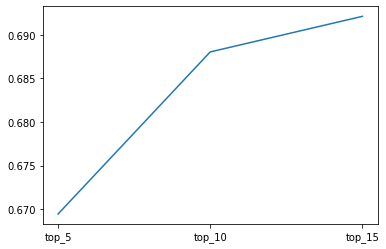

In [201]:
#Proposed Solution

fl_names = ['top_5', 'top_10', 'top_15']

#Get all models with 64% training sample.
models_64 = project.get_models(search_params = {'sample_pct': 64})

#Get all models that have been retrained
retrained_models = [model for model in models_64 for fl in fl_names if fl in str(model.featurelist_name)]

#Calculate cross_validation scores for all of the retrained models

for model in retrained_models:
    try:
        model.cross_validate()
    except:
        pass
    
#Wait for calculations to finish
while len(project.get_all_jobs()) > 0:
    time.sleep(5)

#Query the retrained models again else they will not have their crossValidation score.

#Get all models with 64% training sample.
models_64 = project.get_models(search_params = {'sample_pct': 64})

#Get all models that have been retrained
retrained_models = [model for model in models_64 for fl in fl_names if fl in str(model.featurelist_name)]

#Empty lists to hold results
top_5_cv_scores = []
top_10_cv_scores = []
top_15_cv_scores = []

for model in retrained_models:
    if model.featurelist_name == 'top_5':
        top_5_cv_scores.append(model.metrics['AUC']['crossValidation'])
    elif model.featurelist_name == 'top_10':
        top_10_cv_scores.append(model.metrics['AUC']['crossValidation'])
    else:
        top_15_cv_scores.append(model.metrics['AUC']['crossValidation'])
        
        

#Plot results
values = [mean(top_5_cv_scores), mean(top_10_cv_scores), mean(top_15_cv_scores)]
names = ['top_5', 'top_10', 'top_15']

plt.plot(names,values)

What do you see?

### Verification
To verify that you have completed everything correctly, look at the `Light Gradient Boosting on ElasticNet Predictions` model that was trained on 64% of the data. The cross-validation score for AUC should be `0.6945`.

### Bonus Question

You might have noticed that the first list of models we created had 5 (might change with DR releases) models. It makes sense that since we want to run each one of these models using 3 different feature lists, we should have ended with 15 models. That is not the case as we had 12 models in the end. Can you think why that is the case?

#### Bonus Question Answer:

The 5 models we retrieved are not unique. Some of them are the same just trained on different feature lists. DataRobot identifies that we have already initiated model building with a feature list and it will not create a duplicate model.